### Imports

In [3]:
from data_process.data import LabeledData
from data_process.labels import AnomalyLabel
from data_process.signal_tools import signal_filter, signal_transform
from data_process.utils import ClassifierMetrics, ax_legend_picking, ax_reset_scale
from data_process.detect.rule_based.envelope_threshold import EnvelopeThreshold
import matplotlib.pyplot as plt
import numpy as np
import scipy
# %matplotlib widget

RuntimeError: 'widget is not a recognised GUI loop or backend name

### Load and filter data

In [ ]:
pickle_file = '/home/ntkot/theses/ros/bag_db/data_07_10_2023__17_42_10/rosbag2_07_10_2023__17_42_10/rosbag2_07_10_2023__17_42_10.pkl'
annotation_file = '/home/ntkot/theses/ros/bag_db/data_07_10_2023__17_42_10/rosbag2_07_10_2023__17_42_10/rosbag2_07_10_2023__17_42_10_labels_v3.json'
ignore_ranges_classification = [(185906, 198500)]

original_data = LabeledData(pickle_file, annotation_file)

sample_rate = 1 / np.average(original_data['time']['rel'][1:] - original_data['time']['rel'][0:-1])
print(f'Sample rate: {sample_rate:.3f}Hz')

accel_wiener_window = 21
accel_highpass_order = 3
accel_highpass_critical_frequency = 3

gyro_wiener_window = 21
gyro_highpass_order = 3
gyro_highpass_critical_frequency = 2

accel_wiener = lambda x: signal_filter.wiener(x, accel_wiener_window)
gyro_wiener  = lambda x: signal_filter.wiener(x, gyro_wiener_window)

accel_filter = lambda x: signal_filter.butterworth(signal=x, 
                                                   sample_rate=sample_rate, 
                                                   order=accel_highpass_order,
                                                   critical_freq=accel_highpass_critical_frequency,
                                                   btype='highpass')
gyro_filter  = lambda x: signal_filter.butterworth(signal=x, 
                                                   sample_rate=sample_rate, 
                                                   order=gyro_highpass_order, 
                                                   critical_freq=gyro_highpass_critical_frequency,
                                                   btype='highpass')

wiener_data = original_data.transform(accel_wiener, [['accel', 'x'], ['accel', 'y'], ['accel', 'z']])
wiener_data.transform(gyro_wiener,  [['gyro', 'x'],  ['gyro', 'y'],  ['gyro', 'z']], in_place=True)

final_data = wiener_data.transform(accel_filter, [['accel', 'x'], ['accel', 'y'], ['accel', 'z']])
final_data.transform(gyro_filter,  [['gyro', 'x'],  ['gyro', 'y'],  ['gyro', 'z']], in_place=True)

envelope_fun = lambda x: np.abs(signal_transform.hilbert(x))
envelope_data = final_data.transform(envelope_fun,  [['accel', 'x'], ['accel', 'y'], ['accel', 'z'], 
                                                     ['gyro', 'x'],  ['gyro', 'y'],  ['gyro', 'z']])

data_dict = {'original': original_data, 'wiener': wiener_data, 'final': final_data, 'envelope': envelope_data}

Loading from pickle file...
Sample rate: 99.949Hz


### Plot Highpass filter response

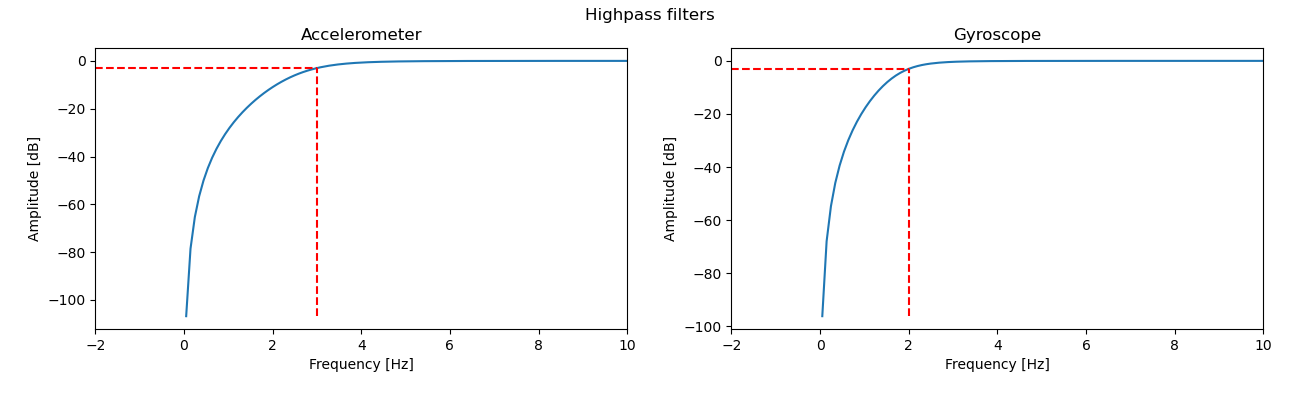

In [ ]:
b_accel, a_accel = scipy.signal.butter(N=accel_highpass_order, Wn=accel_highpass_critical_frequency, btype='highpass', fs=sample_rate, output='ba')
b_gyro,  a_gyro  = scipy.signal.butter(N=gyro_highpass_order,  Wn=gyro_highpass_critical_frequency,  btype='highpass', fs=sample_rate, output='ba')
freqs_accel, w_accel = scipy.signal.freqz(b=b_accel, a=a_accel, fs=sample_rate, worN=np.linspace(0.05, sample_rate/2, 512))
freqs_gyro,  w_gyro  = scipy.signal.freqz(b=b_gyro , a=a_gyro , fs=sample_rate, worN=np.linspace(0.05, sample_rate/2, 512))

# PLOTTING
hp_fig = plt.figure(1)
hp_fig.clear()
hp_fig, hp_ax = plt.subplots(num=1, nrows=1, ncols=2)

hp_ax[0].plot(freqs_accel, 20 * np.log10(np.abs(w_accel)))
hp_ax[0].vlines(x=[accel_highpass_critical_frequency], ymin=min(20 * np.log10(np.abs(w_accel))), ymax=-3, color='r', linestyle='--')
hp_ax[0].hlines(y=-3, xmin=-2, xmax=accel_highpass_critical_frequency, color='r', linestyle='--')
hp_ax[0].set_title('Accelerometer')
hp_ax[0].set_ylabel('Amplitude [dB]')
hp_ax[0].set_xlabel('Frequency [Hz]')
hp_ax[0].set_xlim(-2, 10)

hp_ax[1].plot(freqs_gyro, 20 * np.log10(np.abs(w_gyro)))
hp_ax[1].vlines(x=[gyro_highpass_critical_frequency], ymin=min(20 * np.log10(np.abs(w_gyro))), ymax=-3, color='r', linestyle='--')
hp_ax[1].hlines(y=-3, xmin=-2, xmax=gyro_highpass_critical_frequency, color='r', linestyle='--')
hp_ax[1].set_title('Gyroscope')
hp_ax[1].set_ylabel('Amplitude [dB]')
hp_ax[1].set_xlabel('Frequency [Hz]')
hp_ax[1].set_xlim(-2, 10)

hp_fig.set_size_inches(13,4)
hp_fig.tight_layout(pad=2)
hp_fig.suptitle('Highpass filters')

plt.show()

### Before vs After filtering

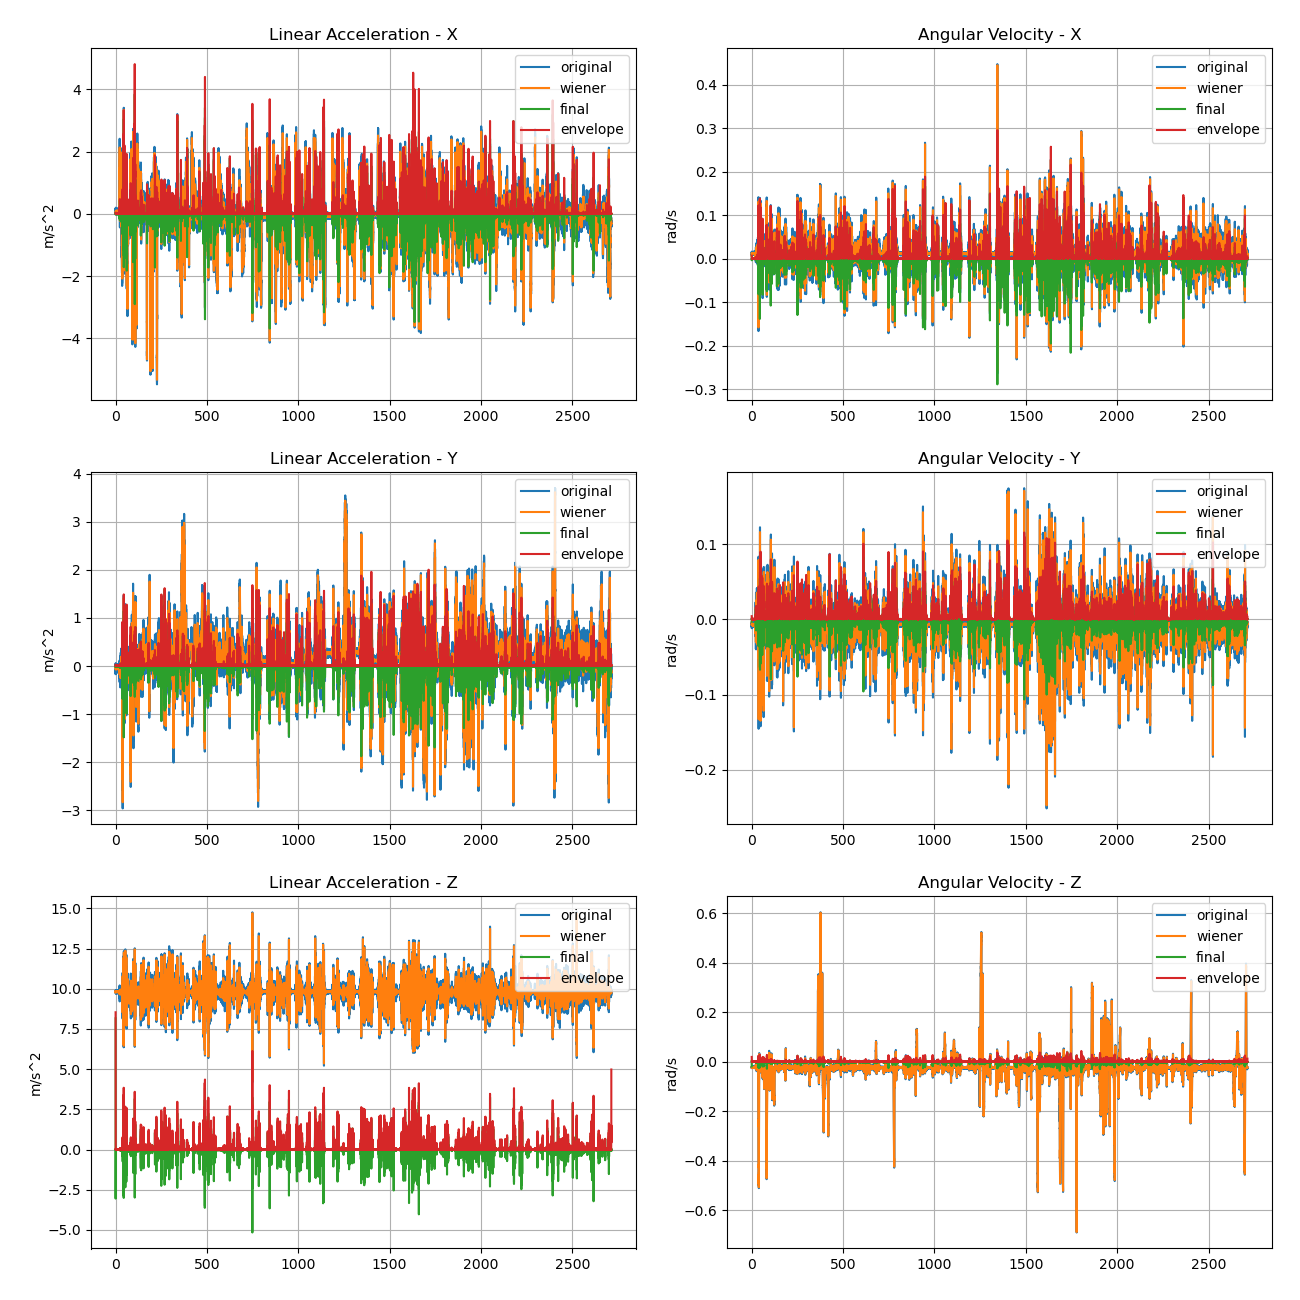

In [ ]:
# If figure was created before, keep same x/y axis limits to allow for fast comparisons in time segments
filter_ax_x_lim = None
filter_ax_y_lim = None
if 'filter_ax' in locals():
    filter_ax_x_lim = filter_ax[0][0].get_xlim()
    filter_ax_y_lim = filter_ax[0][0].get_ylim()

filter_fig = plt.figure(2)
filter_fig.clear()
filter_fig, filter_ax = plt.subplots(num=2, nrows=3, ncols=2, sharex='all')

for key in data_dict.keys():
    filter_ax[0][0].plot(data_dict[key]['time']['rel'], data_dict[key]['accel']['x'], label=key)
filter_ax[0][0].grid(which='both', axis='both')
filter_ax[0][0].legend(loc='upper right')
ax_legend_picking(filter_ax[0][0])
filter_ax[0][0].tick_params(labelbottom=True)
filter_ax[0][0].set_ylabel('m/s^2')
filter_ax[0][0].set_title('Linear Acceleration - X')

for key in data_dict.keys():
    filter_ax[1][0].plot(data_dict[key]['time']['rel'], data_dict[key]['accel']['y'], label=key)
filter_ax[1][0].grid(which='both', axis='both')
filter_ax[1][0].legend(loc='upper right')
ax_legend_picking(filter_ax[1][0])
filter_ax[1][0].tick_params(labelbottom=True)
filter_ax[1][0].set_ylabel('m/s^2')
filter_ax[1][0].set_title('Linear Acceleration - Y')

for key in data_dict.keys():
    filter_ax[2][0].plot(data_dict[key]['time']['rel'], data_dict[key]['accel']['z'], label=key)
filter_ax[2][0].grid(which='both', axis='both')
filter_ax[2][0].legend(loc='upper right')
ax_legend_picking(filter_ax[2][0])
filter_ax[2][0].tick_params(labelbottom=True)
filter_ax[2][0].set_ylabel('m/s^2')
filter_ax[2][0].set_title('Linear Acceleration - Z')

for key in data_dict.keys():
    filter_ax[0][1].plot(data_dict[key]['time']['rel'], data_dict[key]['gyro']['x'], label=key)
filter_ax[0][1].grid(which='both', axis='both')
filter_ax[0][1].legend(loc='upper right')
ax_legend_picking(filter_ax[0][1])
filter_ax[0][1].tick_params(labelbottom=True)
filter_ax[0][1].set_ylabel('rad/s')
filter_ax[0][1].set_title('Angular Velocity - X')

for key in data_dict.keys():
    filter_ax[1][1].plot(data_dict[key]['time']['rel'], data_dict[key]['gyro']['y'], label=key)
filter_ax[1][1].grid(which='both', axis='both')
filter_ax[1][1].legend(loc='upper right')
ax_legend_picking(filter_ax[1][1])
filter_ax[1][1].tick_params(labelbottom=True)
filter_ax[1][1].set_ylabel('rad/s')
filter_ax[1][1].set_title('Angular Velocity - Y')

for key in data_dict.keys():
    filter_ax[2][1].plot(data_dict[key]['time']['rel'], data_dict[key]['gyro']['z'], label=key)
filter_ax[2][1].grid(which='both', axis='both')
filter_ax[2][1].legend(loc='upper right')
ax_legend_picking(filter_ax[2][1])
filter_ax[2][1].tick_params(labelbottom=True)
filter_ax[2][1].set_ylabel('rad/s')
filter_ax[2][1].set_title('Angular Velocity - Z')

filter_fig.set_size_inches(13,13)
filter_fig.tight_layout(pad=2)

if (filter_ax_x_lim is not None) and (filter_ax_y_lim is not None):
    filter_ax[0][0].set_xlim(filter_ax_x_lim)
    filter_ax[0][0].set_ylim(filter_ax_y_lim)

filter_fig.canvas.mpl_connect('key_press_event', lambda event: ax_reset_scale(event, filter_ax[0][0]))

plt.show()

### Use EnvelopeThreshold detection method on z component of linear acceleration

Stats:
  Total points:       271148
  Anomaly points:     32653 (12.04 %) (573 zones)
  Non-anomaly points: 238495 (87.96 %)

Metrics:
  Overall:
    Accuracy:   0.9630
    Precision:  0.9170
    Recall:     0.9159
    F1-Measure: 0.9164
  Anomalies:
    Accuracy:   0.9630
    Precision:  0.8553
    Recall:     0.8528
    F1-Measure: 0.8540
  Non-Anomalies:
    Accuracy:   0.9630
    Precision:  0.9786
    Recall:     0.9790
    F1-Measure: 0.9788


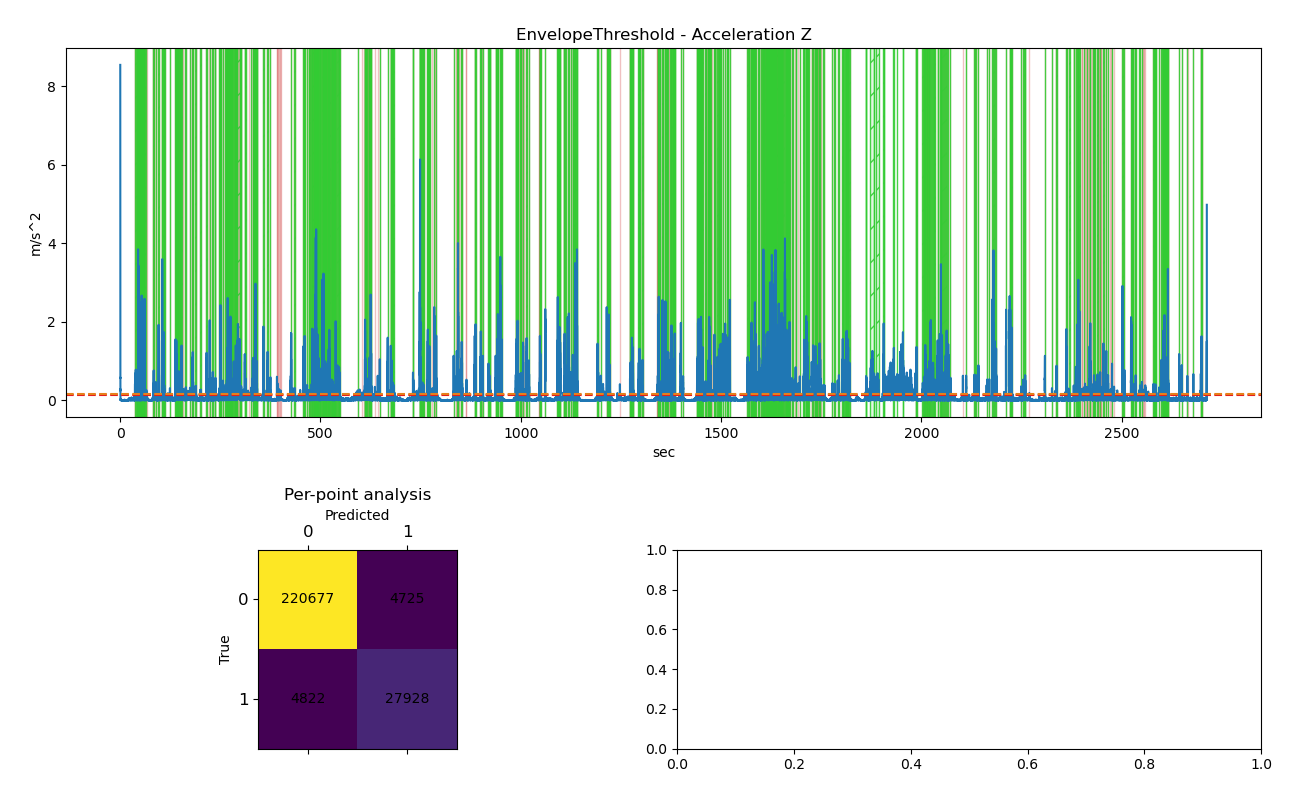

In [ ]:
start_value_threshold = 0.125
stop_value_threshold = 0.15
start_counter_threshold = 11
stop_counter_threshold = 8
ignore_ranges_classification = [[0, 200], [185906, 198500], [-200, -1]]

detector = EnvelopeThreshold(start_value_threshold=start_value_threshold, stop_value_threshold=stop_value_threshold,
                             start_counter_threshold=start_counter_threshold, stop_counter_threshold=stop_counter_threshold)
detector.predict(envelope_data['accel']['z'], ignore_ranges=ignore_ranges_classification)
detected_slices = [(start, stop) 
                   for start, stop in zip(detector.anomalies_start_idx, detector.anomalies_stop_idx)]

# STATS/METRICS
y_true = [1 
          if point_labels and (not AnomalyLabel.NO_ANOMALY in [label.anomaly for label in point_labels]) 
          else 0 
          for point_labels in envelope_data.labels]
y_pred = detector.to_time_samples(envelope_data['time']['rel'])

cm = ClassifierMetrics.confusion_matrix(y_true, y_pred, ignore_ranges=ignore_ranges_classification)
overall_metrics = ClassifierMetrics.overall_metrics_from_cm(cm)
class_metrics = ClassifierMetrics.class_metrics_from_cm(cm)

anomaly_zones = len(detector.anomalies_start_idx)
anomaly_points = sum([len(range(start, stop+1)) for start, stop in zip(detector.anomalies_start_idx, detector.anomalies_stop_idx)])
non_anomaly_points = len(envelope_data['accel']['z']) - anomaly_points
print(f'Stats:\n' + \
      f'  Total points:       {len(envelope_data["accel"]["z"])}\n' + \
      f'  Anomaly points:     {anomaly_points} ({(anomaly_points / len(envelope_data["accel"]["z"]) * 100.0):.2f} %) ({anomaly_zones} zones)\n' + \
      f'  Non-anomaly points: {non_anomaly_points} ({(non_anomaly_points / len(envelope_data["accel"]["z"]) * 100.0):.2f} %)\n')
print(f'Metrics:\n' + \
      f'  Overall:\n' + \
      f'    Accuracy:   {overall_metrics["accuracy"]:.4f}\n' + \
      f'    Precision:  {overall_metrics["precision"]:.4f}\n' + \
      f'    Recall:     {overall_metrics["recall"]:.4f}\n' + \
      f'    F1-Measure: {overall_metrics["f1_measure"]:.4f}\n' + \
      f'  Anomalies:\n' + \
      f'    Accuracy:   {class_metrics["accuracy"][1]:.4f}\n' + \
      f'    Precision:  {class_metrics["precision"][1]:.4f}\n' + \
      f'    Recall:     {class_metrics["recall"][1]:.4f}\n' + \
      f'    F1-Measure: {class_metrics["f1_measure"][1]:.4f}\n' + \
      f'  Non-Anomalies:\n' + \
      f'    Accuracy:   {class_metrics["accuracy"][0]:.4f}\n' + \
      f'    Precision:  {class_metrics["precision"][0]:.4f}\n' + \
      f'    Recall:     {class_metrics["recall"][0]:.4f}\n' + \
      f'    F1-Measure: {class_metrics["f1_measure"][0]:.4f}')


# PLOTTING
pred_fig = plt.figure(3)
pred_fig.clear()
gs_kw = dict(height_ratios=[0.65, 0.35])
pred_fig, pred_ax = plt.subplot_mosaic(num=3, mosaic=[['plot', 'plot'],
                                                      ['cm_points', 'cm_zones']], gridspec_kw=gs_kw)

pred_ax['plot'].plot(envelope_data['time']['rel'], envelope_data['accel']['z'])
pred_ax['plot'].axhline(y=start_value_threshold, linestyle='--', color=(0.9, 0.1, 0.1))
pred_ax['plot'].axhline(y=stop_value_threshold, linestyle='--', color=(0.9, 0.5, 0.1))
# plt.scatter(envelope_data['time']['rel'], y_pred, color='r', marker='*', s=6)
# plt.scatter(envelope_data['time']['rel'], y_true, color='g', marker='*', s=2)
# for start, stop in zip(detector.anomalies_start_idx, detector.anomalies_stop_idx):
#     pred_ax['plot'].axvspan(xmin=envelope_data['time']['rel'][start], xmax=envelope_data['time']['rel'][stop], color=(0.8, 0.2, 0.2, 0.3))
# for ann in envelope_data.annotations.items:
#     if ann.label.anomaly != AnomalyLabel.NO_ANOMALY:
#         pred_ax['plot'].axvspan(xmin=ann.rel_t_start, xmax=ann.rel_t_end, color=(0.2, 0.8, 0.2, 0.3))
for i, (start, stop) in enumerate(zip(detector.anomalies_start_idx, detector.anomalies_stop_idx)):
        pred_ax['plot'].axvspan(xmin=envelope_data['time']['rel'][start], xmax=envelope_data['time']['rel'][stop], color=(0.8, 0.2, 0.2, 0.3),
                    label="_"*i + "Πρόβλεψη")
# Ground-truth regions
for i, ann in enumerate(envelope_data.annotations.items):
    if ann.label.anomaly != AnomalyLabel.NO_ANOMALY:
        pred_ax['plot'].axvspan(xmin=ann.rel_t_start, xmax=ann.rel_t_end, edgecolor=(0.2, 0.8, 0.2, 0.9), facecolor=(0.2, 0.8, 0.2, 0.15),
                    label="_"*i + "Θεμελιώδης\nΑλήθεια", hatch='/')
pred_ax['plot'].set_xlabel('sec')
pred_ax['plot'].set_ylabel('m/s^2')
pred_ax['plot'].set_title('EnvelopeThreshold - Acceleration Z')

pred_ax['cm_points'].matshow(cm)
pred_ax['cm_points'].set_xlabel('Predicted')
pred_ax['cm_points'].xaxis.set_label_position('top') 
pred_ax['cm_points'].set_ylabel('True')
pred_ax['cm_points'].set_xticks(range(cm.shape[0]))
pred_ax['cm_points'].set_yticks(range(cm.shape[0]))
pred_ax['cm_points'].set_xticklabels(range(cm.shape[0]), fontsize=12)
pred_ax['cm_points'].set_yticklabels(range(cm.shape[0]), fontsize=12)
for (i, j), z in np.ndenumerate(cm):
    pred_ax['cm_points'].text(j, i, '{:d}'.format(z), ha='center', va='center')
pred_ax['cm_points'].set_title('Per-point analysis')

pred_fig.set_size_inches(13,8)
pred_fig.tight_layout(pad=2)

plt.show()